In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from pyramid.arima import auto_arima
import itertools
import warnings
warnings.filterwarnings("ignore")
from math import sqrt

C:\Users\User\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [3]:
df=pd.read_csv("dd.csv")
df1=df[df.ItemId==972142]

In [4]:
df2=df1[['WeekNoinTotal','QTY']]
df2=df2.set_index('WeekNoinTotal')
df2.head()

,QTY
WeekNoinTotal,
1,4
2,35
3,46
4,39
5,31


Text(0.5, 0, 'WeekNoinTotal')

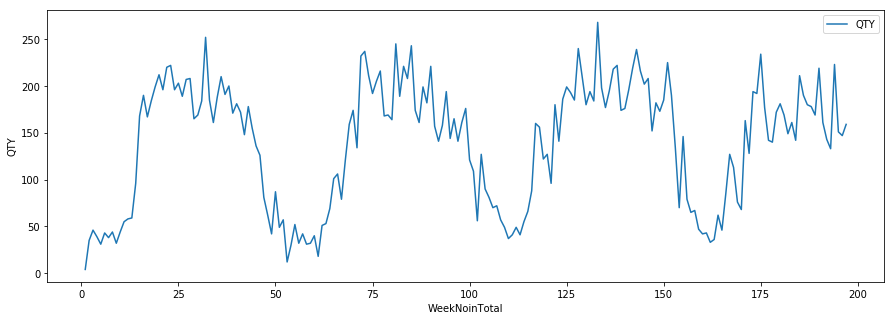

In [5]:
df2.plot(figsize=(15,5))
plt.ylabel('QTY')
plt.xlabel('WeekNoinTotal')

In [6]:
train = df2[:int(0.7*len(df2))]
test = df2[int(0.7*len(df2)):]

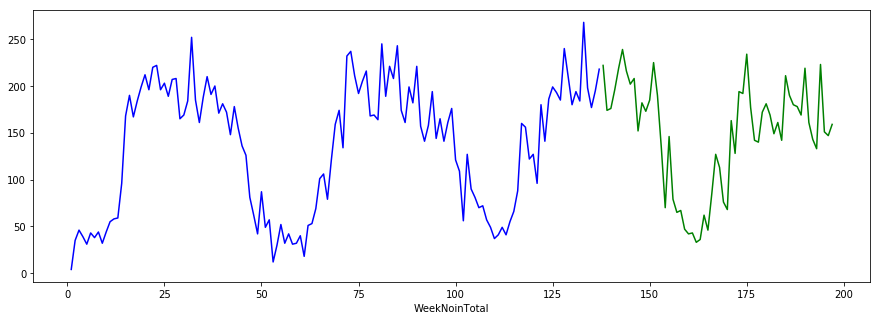

In [7]:
f1=train['QTY'].plot(color='blue', figsize=(15,5))
f2=test['QTY'].plot(color='green', figsize=(15,5))

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    #rolstd = pd.rolling_std(timeseries, window=52)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 3))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','#Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    if (dfoutput['p-value']>0.05):
        print("Data is Not Stationary, Null hypothesis:Data is non-stationary cannot be rejected")
    else:
        print('Data is Stationary and Null hypothesis of data being non-stationary is rejected')

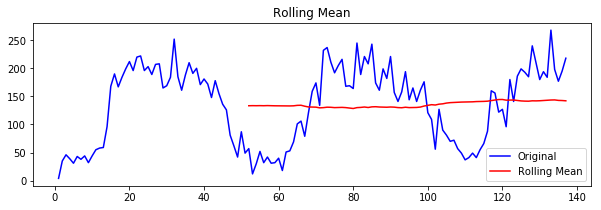

Results of Dickey-Fuller Test:
Test Statistic           -4.038115
p-value                   0.001224
#Lags Used               11.000000
#Observations Used      125.000000
Critical Value (1%)      -3.483779
Critical Value (5%)      -2.884954
Critical Value (10%)     -2.579257
dtype: float64
Data is Stationary and Null hypothesis of data being non-stationary is rejected


In [9]:
test_stationarity(train['QTY'])

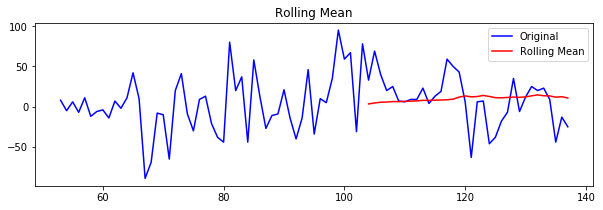

Results of Dickey-Fuller Test:
Test Statistic         -6.811265e+00
p-value                 2.113341e-09
#Lags Used              0.000000e+00
#Observations Used      8.400000e+01
Critical Value (1%)    -3.510712e+00
Critical Value (5%)    -2.896616e+00
Critical Value (10%)   -2.585482e+00
dtype: float64
Data is Stationary and Null hypothesis of data being non-stationary is rejected


In [10]:
train['seasonal_diff'] = train.QTY - train.QTY.shift(52)
test_stationarity(train.seasonal_diff.dropna(inplace=False))

In [11]:
train['seasonal_diff'].dropna(inplace=True)

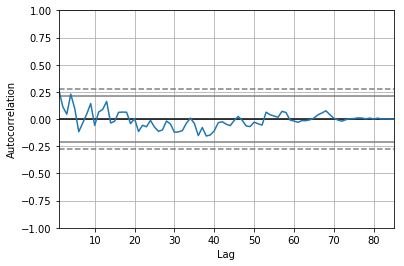

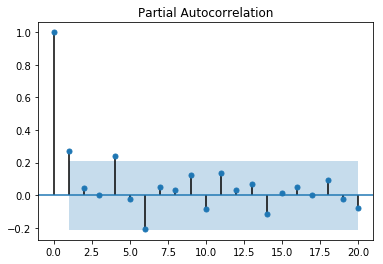

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
autocorrelation_plot(train.seasonal_diff);
plot_pacf(train.seasonal_diff, lags=20);

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [14]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train['QTY'], order=param, seasonal_order=param_seasonal)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            

ARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:1766.9418455460327
ARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:847.53724332387
ARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:1518.587262659625
ARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:848.6719783619646
ARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:1626.3956007451307
ARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:843.4129607680403
ARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:1482.2203230937766
ARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:844.1436921165174
ARIMA(0, 1, 0)x(0, 0, 0, 52) - AIC:1333.0607912203761
ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:867.8092457187095
ARIMA(0, 1, 0)x(1, 0, 0, 52) - AIC:1332.617864641331
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:867.7401143759697
ARIMA(0, 1, 1)x(0, 0, 0, 52) - AIC:1321.297578714093
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:838.0128857144604
ARIMA(0, 1, 1)x(1, 0, 0, 52) - AIC:1317.1620087667966
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:839.3462463266426
ARIMA(1, 0, 0)x(0, 0, 0, 52) - AIC:1346.4276287042285
ARIMA(1, 0, 0)x(0, 1, 0, 52) - AIC:842.1789579873656
ARIMA(1, 0, 0)x(1, 0, 0, 52) - AIC:1345.27

In [15]:
# fit model
model = sm.tsa.statespace.SARIMAX(train['QTY'], order=(1,1,1), seasonal_order=(1,1,0,52))
result = model.fit(disp=0)
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                QTY   No. Observations:                  137
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 52)   Log Likelihood                -415.157
Date:                            Fri, 11 Jan 2019   AIC                            838.313
Time:                                    17:28:52   BIC                            848.036
Sample:                                         0   HQIC                           842.222
                                            - 137                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2319      0.114      2.027      0.043       0.008       0.456
ma.L1         -0.9282      0.054   

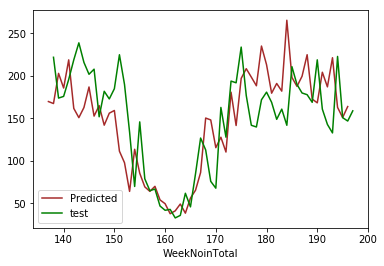

In [24]:
pred = result.get_forecast(steps=60)
#ax = df2['QTY'].plot(figsize=(15, 5), label='Observed', color='blue')
pred.predicted_mean.plot( label='Predicted', color='brown')
test['QTY'].plot(color='green', label='test')
plt.legend()

In [18]:
predicted = pred.predicted_mean
truth = test['QTY']
rmse = sqrt(((predicted - truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 45.81


In [21]:
mean=train['QTY'].mean()
mean

135.4963503649635

In [22]:
rmse/mean


0.33805879032442554

In [23]:
(((predicted-truth)/truth).abs()).mean()

0.25875871755254637